## Importing all the dependencies

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import openai
from langchain_openai import ChatOpenAI
from collections import Counter
from sentence_transformers import SentenceTransformer, util
import os
from datasets import Dataset, Features, Sequence, Value
from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision,
)

## **Calculating Context Precision, Context Recall, Faithfulness, Answer Relevancy**

In [ ]:
df = pd.read_csv('/datasets/results.csv')

# Prepare the data dictionary for the Dataset
data = {
    "question": [str(q) for q in df["Question"].tolist()],
    "ground_truth": [str(gt) for gt in df["Answer"].tolist()],
    "answer": [str(output) for output in df["llm_output"].tolist()],
    "contexts": [str(ctx).split() for ctx in df["context"].tolist()],
}

# Define the schema for the Dataset
features = Features({
    "question": Value("string"),
    "ground_truth": Value("string"),
    "answer": Value("string"),
    "contexts": Sequence(Value("string")),
})

# Create a Dataset from the data dictionary and the defined features
dataset = Dataset.from_dict(data, features=features)

# Split the dataset into 25 approximately equal parts
num_splits = 25
splits = np.array_split(dataset.to_pandas(), num_splits)

In [ ]:
# Function to Evaluate each split
def process_split(split):
    split_dataset = Dataset.from_pandas(split, features=features)

    result = evaluate(
        dataset=split_dataset,
        metrics=[
            context_precision,
            context_recall,
            faithfulness,
            answer_relevancy,
        ],
    )
    return result.to_pandas()

In [ ]:
# Process each split and concatenate the results
combined_results = pd.DataFrame()

for i, split in enumerate(splits):
    print(f"Processing split {i+1}/{num_splits}...")
    split_result = process_split(split)
    combined_results = pd.concat([combined_results, split_result], ignore_index=True)
    print(f"Finished processing split {i+1}/{num_splits}.")
    time.sleep(10)

csv_file_path = "/datasets/RAGA_results.csv"
combined_results.to_csv(csv_file_path, index=False)

In [89]:
# Calcualting average to get percent
averages = df.mean(numeric_only=True)

print("Average Faithfulness:", averages['faithfulness'])
print("Average Answer Relevancy:", averages['answer_relevancy'])
print("Average Context Recall:", averages['Context_Recall'])
print("Average Context Precision:", averages['Context_Precision'])

Average Faithfulness: 0.7312064884433306
Average Answer Relevancy: 0.8765342009172743
Average Context Recall: 0.7178362573099415
Average Context Precision: 0.8435672514619882


## **Calculating Semantic Similarity Score**

In [ ]:
# Load the pre-trained sentence transformer model
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [33]:
similarity_scores = []

for _, row in df.iterrows():

    # Extract the ground truth answer and the model output from the DataFrame row
    ground_truth = str(row['Answer'])
    llm_output = str(row['llm_output'])

    # Compute the cosine similarity between the embeddings of the ground truth and model output
    similarity_score = util.pytorch_cos_sim(model.encode(ground_truth), model.encode(llm_output)).item()
    similarity_scores.append(similarity_score)

# Calculate the average similarity score
average_similarity_score = sum(similarity_scores) / len(similarity_scores)
print(f"Average semantic similarity score: {average_similarity_score:.4f}")

Average semantic similarity score: 0.7610


# **Calculating Hallucinations**

In [ ]:
model = ChatOpenAI(model='gpt-4', max_tokens=3)

In [ ]:
# Define a function to compare the submitted answer with the expert answer
def compare_answers_langchain(question, ground_truth, llm_output):

    # Create a prompt to compare the factual content of the submitted answer with the expert answer
    prompt = f"""
    ************
    [Question]: {question}
    ************
    [Expert]: {ground_truth}
    ************
    [Submission]: {llm_output}
    ************
    Compare the factual content of the submitted answer with the expert answer. Ignore any differences in style, grammar, or punctuation.
    Answer the question by selecting one of the following options:
    (A) The submitted answer is a subset of the expert answer and is fully consistent with it.
    (B) The submitted answer is a superset of the expert answer and is fully consistent with it.
    (C) The submitted answer contains all the same details as the expert answer.
    (D) There is a disagreement between the submitted answer and the expert answer.
    (E) The answers differ, but these differences don't matter from the perspective of factuality.
    """
    response = model.invoke(prompt)

    return response

In [76]:
comparison_results_langchain = []

# Call the function to compare answers and store the result
for index, row in df.iterrows():
    question = row['Question']
    ground_truth = row['Answer']
    llm_output = row['llm_output']

    comparison_result_langchain = compare_answers_langchain(question, ground_truth, llm_output)
    comparison_results_langchain.append(comparison_result_langchain)

Comparison results using langchain:
[AIMessage(content='(B) The', response_metadata={'token_usage': {'completion_tokens': 3, 'prompt_tokens': 255, 'total_tokens': 258}, 'model_name': 'gpt-4', 'system_fingerprint': None, 'finish_reason': 'length', 'logprobs': None}, id='run-bdc42512-4c7c-4722-af3c-7c124acb26b0-0', usage_metadata={'input_tokens': 255, 'output_tokens': 3, 'total_tokens': 258}), AIMessage(content='(B) The', response_metadata={'token_usage': {'completion_tokens': 3, 'prompt_tokens': 473, 'total_tokens': 476}, 'model_name': 'gpt-4', 'system_fingerprint': None, 'finish_reason': 'length', 'logprobs': None}, id='run-1b362bf4-b3dd-470e-8bea-131c20a2e02c-0', usage_metadata={'input_tokens': 473, 'output_tokens': 3, 'total_tokens': 476}), AIMessage(content='(D) There', response_metadata={'token_usage': {'completion_tokens': 3, 'prompt_tokens': 486, 'total_tokens': 489}, 'model_name': 'gpt-4', 'system_fingerprint': None, 'finish_reason': 'length', 'logprobs': None}, id='run-41316dcd

In [81]:
Hallucinations = ['B','B','D','C','D','D','C','C','C','B','A','B','C','C','C','B','C','C','B','A','C','C','C','B','C','B','B','B','B','B','B','B','B','B','B','B','B','B','D','D','B','D','B','B','D','B','B','B','B','E','B','B','B','D','B','B','C']

## **Visualizing Hallucinations Results**

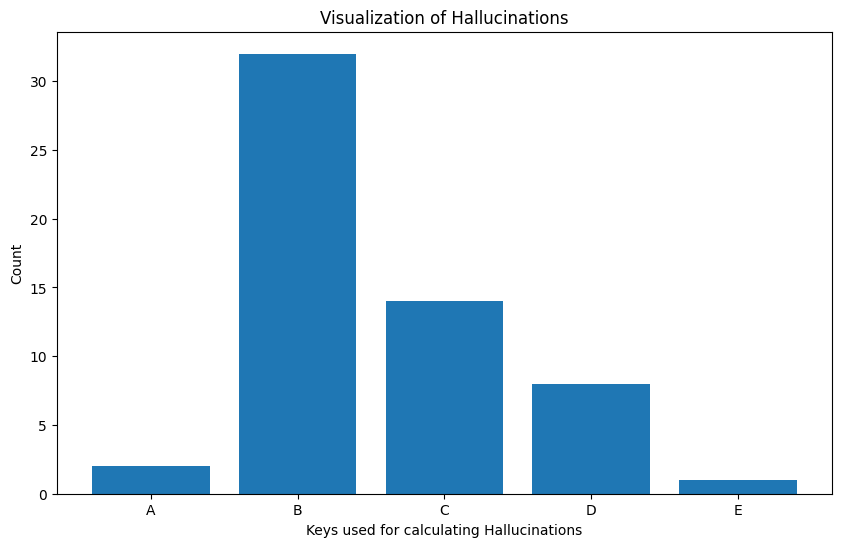

In [88]:
key = {
    'A': 'The submitted answer is a subset of the expert answer and is fully consistent with it.',
    'B': 'The submitted answer is a superset of the expert answer and is fully consistent with it.',
    'C': 'The submitted answer contains all the same details as the expert answer.',
    'D': 'There is a disagreement between the submitted answer and the expert answer.',
    'E': 'The answers differ, but these differences don\'t matter from the perspective of factuality.'
}

counts = Counter(Hallucinations)

labels = list(key.keys())
values = [counts[label] for label in labels]

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(labels, values)

ax.set_xlabel('Keys used for calculating Hallucinations')
ax.set_ylabel('Count')
ax.set_title('Visualization of Hallucinations')

plt.xticks()
plt.show()

**Significance of Each Alphabet**


    'A': 'The submitted answer is a subset of the expert answer and is fully consistent with it.'
    'B': 'The submitted answer is a superset of the expert answer and is fully consistent with it.'
    'C': 'The submitted answer contains all the same details as the expert answer.'
    'D': 'There is a disagreement between the submitted answer and the expert answer.'
    'E': 'The answers differ, but these differences don't matter from the perspective of factuality.'